# Air transportation Ocurrences
## Analyzing Probabilities 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../scripts")

In [4]:
from data_loader import load_data_from_csv, load_data_from_temp
from common.export_csv import exportDataVersion
import pandas as pd
import numpy as np

In [5]:
#Load data
df = load_data_from_csv('fullData_V2.csv')
#Data length
print(f"# of rows 'fullData_V2.csv': {len(df)}")

# of rows 'fullData_V2.csv': 47781


### Marginal Probabilities 

In [7]:
import matplotlib.pyplot as plt

In [8]:
color_palette = ['#957fec', '#fff071', '#e3d9a7', '#e3a7d5', '#5ecfce',
                 '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', 
                 '#ffff33', '#a65628', '#f781bf', '#999999', '#66c2a5', 
                 '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', 
                 '#e5c494']

In [9]:
province_probabilities = df.groupby('ProvinceID_DisplayEng').agg({
    'OccID': 'count',  # Número de incidentes
    'DamageLevelID_DisplayEng': lambda x: x.value_counts(normalize=True).to_dict(),
    'OperationTypeID_DisplayEng': lambda x: x.value_counts(normalize=True).to_dict(),
    'OperatorTypeID_DisplayEng' : lambda x: x.value_counts(normalize=True).to_dict(),
    'AircraftTypeID_DisplayEng': lambda x: x.value_counts(normalize=True).to_dict(),
    'InjuriesEnum_DisplayEng': lambda x: x.value_counts(normalize=True).to_dict(),
    'YearOfManuf': 'mean'  
}).rename(columns={'OccID': 'IncidentCount'})


#### Marginal Probability of an Accident Occurring in a Specific Province.

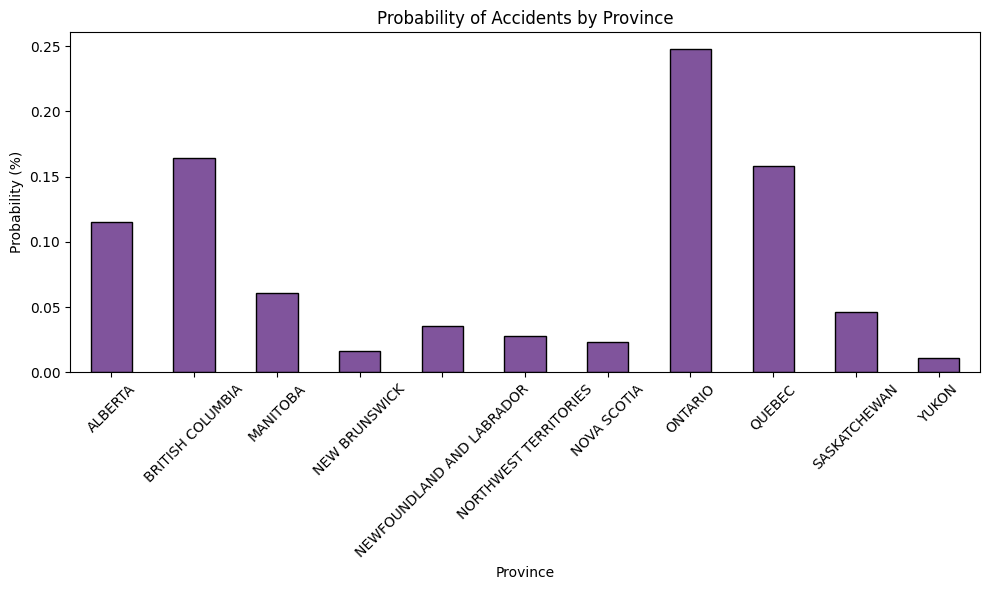

In [11]:
incident_probabilities = province_probabilities['IncidentCount'] / province_probabilities['IncidentCount'].sum()

#Showing most frequent provinces
threshold = 0.01 / incident_probabilities.sum()
filtered_province_probabilities = incident_probabilities[incident_probabilities > threshold]

filtered_province_probabilities.plot(kind='bar', figsize=(10, 6), color='#80549c', edgecolor='black')
plt.title('Probability of Accidents by Province')
plt.xlabel('Province')
plt.ylabel('Probability (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
filtered_province_probabilities_df = filtered_province_probabilities.reset_index()
filtered_province_probabilities_df.head(11)

,ProvinceID_DisplayEng,IncidentCount
0,ALBERTA,0.115404
1,BRITISH COLUMBIA,0.163897
2,MANITOBA,0.061009
3,NEW BRUNSWICK,0.016199
4,NEWFOUNDLAND AND LABRADOR,0.035475
5,NORTHWEST TERRITORIES,0.028003
6,NOVA SCOTIA,0.022897
7,ONTARIO,0.248158
8,QUEBEC,0.158497
9,SASKATCHEWAN,0.046484


#### Marginal probability of each damage level in a specific province.

In [14]:
selected_provinces = [
    'ALBERTA', 'BRITISH COLUMBIA', 'MANITOBA', 'NEW BRUNSWICK',
    'NEWFOUNDLAND AND LABRADOR', 'NORTHWEST TERRITORIES',
    'NOVA SCOTIA', 'ONTARIO', 'QUEBEC', 'SASKATCHEWAN', 'YUKON'
]

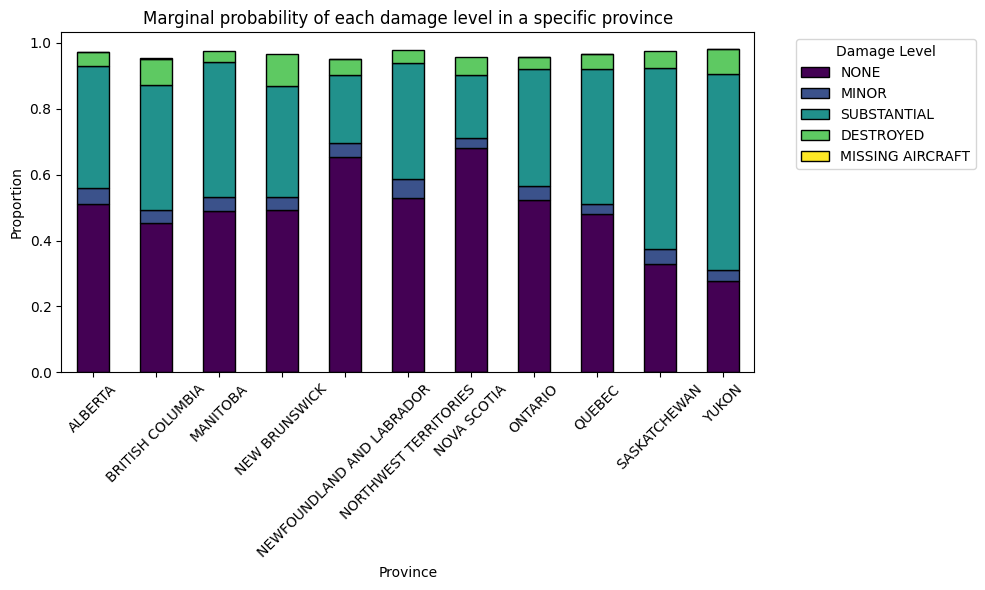

In [15]:
damage_levels = (
    df.groupby(['ProvinceID_DisplayEng', 'DamageLevelID_DisplayEng'])
    .size()
    .unstack(fill_value=0)  #Creating columns for each damage level
    .apply(lambda x: x / x.sum(), axis=1)  #Calculating proportions
)
selected_provinces = [province.upper() for province in selected_provinces]
damage_levels.index = damage_levels.index.str.upper()

damage_levels_filtered = damage_levels.loc[damage_levels.index.intersection(selected_provinces)]
if 'UNKNOWN' in damage_levels_filtered.columns:
    damage_levels_filtered = damage_levels_filtered.drop(columns=['UNKNOWN'])

#Sorting damage level
ordered_columns = ['NONE', 'MINOR', 'SUBSTANTIAL', 'DESTROYED','MISSING AIRCRAFT']
damage_levels_filtered = damage_levels_filtered[ordered_columns]

#Graph
damage_levels_filtered.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title('Marginal probability of each damage level in a specific province')
plt.ylabel('Proportion')
plt.xlabel('Province')
plt.xticks(rotation=45)
plt.legend(title='Damage Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [16]:
damage_levels_filtered.head(11)

DamageLevelID_DisplayEng,NONE,MINOR,SUBSTANTIAL,DESTROYED,MISSING AIRCRAFT
ProvinceID_DisplayEng,,,,,
ALBERTA,0.509793,0.049329,0.370149,0.044070,0.000363
BRITISH COLUMBIA,0.453199,0.038309,0.379773,0.079811,0.003192
MANITOBA,0.490909,0.042882,0.408576,0.033962,0.000000
NEW BRUNSWICK,0.492248,0.041344,0.334625,0.098191,0.000000
NEWFOUNDLAND AND LABRADOR,0.652507,0.043658,0.206490,0.049558,0.000590
NORTHWEST TERRITORIES,0.528401,0.057549,0.352018,0.041854,0.000000
NOVA SCOTIA,0.680987,0.030165,0.192870,0.053931,0.000000
ONTARIO,0.522898,0.044025,0.354390,0.034916,0.000506
QUEBEC,0.481183,0.030635,0.407632,0.047141,0.000132


#### Marginal probability of each type of operation in a specific province

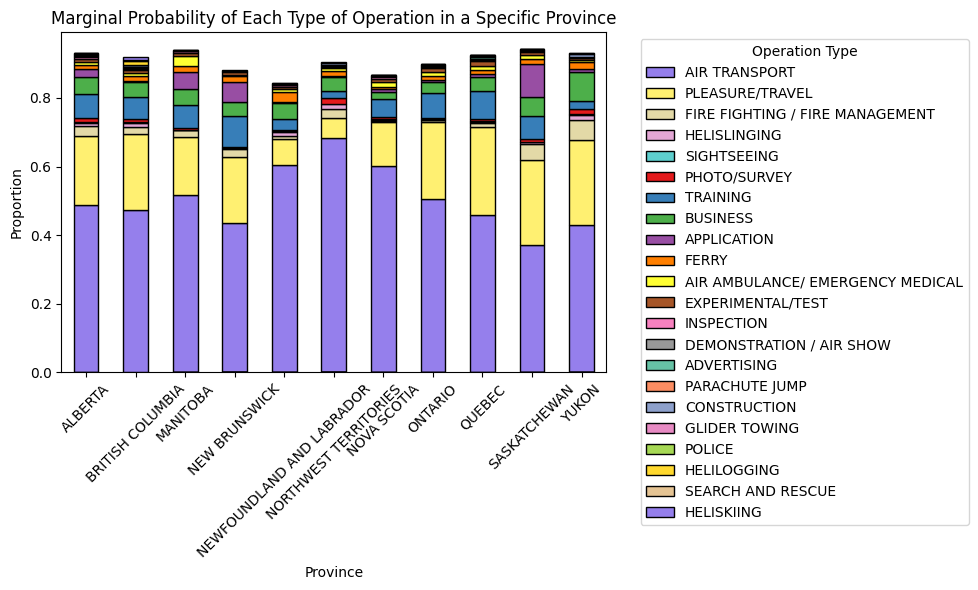

In [18]:
operation_types = pd.DataFrame(province_probabilities['OperationTypeID_DisplayEng'].tolist(),
                               index=province_probabilities.index).fillna(0)

operation_types.index = operation_types.index.str.upper()
operation_types_filtered = operation_types.loc[operation_types.index.intersection(selected_provinces)]

operation_types_filtered = operation_types_filtered.drop(columns=['UNKNOWN', 'OTHER'])
    
operation_types_filtered.plot(kind='bar', stacked=True, figsize=(10, 6), color=color_palette, edgecolor='black')
plt.title('Marginal Probability of Each Type of Operation in a Specific Province')
plt.ylabel('Proportion')
plt.xlabel('Province')
plt.xticks(rotation=45)
plt.legend(title='Operation Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [19]:
operation_types_filtered.head(11)

,AIR TRANSPORT,PLEASURE/TRAVEL,FIRE FIGHTING / FIRE MANAGEMENT,HELISLINGING,SIGHTSEEING,PHOTO/SURVEY,TRAINING,BUSINESS,APPLICATION,FERRY,...,INSPECTION,DEMONSTRATION / AIR SHOW,ADVERTISING,PARACHUTE JUMP,CONSTRUCTION,GLIDER TOWING,POLICE,HELILOGGING,SEARCH AND RESCUE,HELISKIING
ProvinceID_DisplayEng,,,,,,,,,,,,,,,,,,,,,
ALBERTA,0.487486,0.200218,0.031012,0.009068,0.002539,0.011063,0.071092,0.048966,0.022488,0.011970,...,0.007254,0.003627,0.002176,0.001451,0.001451,0.000907,0.000725,0.000363,0.000181,0.0000
BRITISH COLUMBIA,0.473630,0.220917,0.021964,0.011876,0.001915,0.008556,0.063977,0.042651,0.005236,0.013153,...,0.002682,0.001915,0.000894,0.002299,0.004597,0.000383,0.001405,0.012259,0.000638,0.0083
MANITOBA,0.516638,0.170497,0.018182,0.001715,0.001029,0.005146,0.066895,0.045283,0.050086,0.016467,...,0.003774,0.001029,0.000686,0.001372,0.001029,0.000686,0.000000,0.000000,0.000000,0.0000
NEW BRUNSWICK,0.436693,0.192506,0.023256,0.001292,0.001292,0.001292,0.090439,0.042636,0.058140,0.016796,...,0.000000,0.002584,0.001292,0.000000,0.000000,0.000000,0.002584,0.000000,0.000000,0.0000
NEWFOUNDLAND AND LABRADOR,0.604130,0.075516,0.008850,0.012979,0.001180,0.005310,0.029499,0.046608,0.003540,0.029499,...,0.004130,0.000590,0.001770,0.000000,0.002950,0.000000,0.000590,0.000000,0.001180,0.0000
NORTHWEST TERRITORIES,0.683109,0.059043,0.026158,0.012706,0.000000,0.019432,0.018685,0.042601,0.001495,0.014200,...,0.002990,0.000000,0.002990,0.000000,0.005979,0.000000,0.000747,0.000000,0.000000,0.0000
NOVA SCOTIA,0.601463,0.129799,0.000914,0.004570,0.000914,0.005484,0.053016,0.021938,0.009141,0.004570,...,0.005484,0.003656,0.000914,0.000914,0.000914,0.000914,0.000000,0.000000,0.000914,0.0000
ONTARIO,0.506368,0.222569,0.005988,0.002108,0.001687,0.003036,0.072109,0.032386,0.006663,0.012145,...,0.001181,0.002446,0.001434,0.002024,0.000759,0.001434,0.000590,0.000000,0.000084,0.0000
QUEBEC,0.458471,0.257890,0.009904,0.003565,0.002641,0.007131,0.080285,0.040011,0.009375,0.010828,...,0.003301,0.001188,0.005414,0.001849,0.002773,0.000924,0.000792,0.000132,0.000660,0.0000


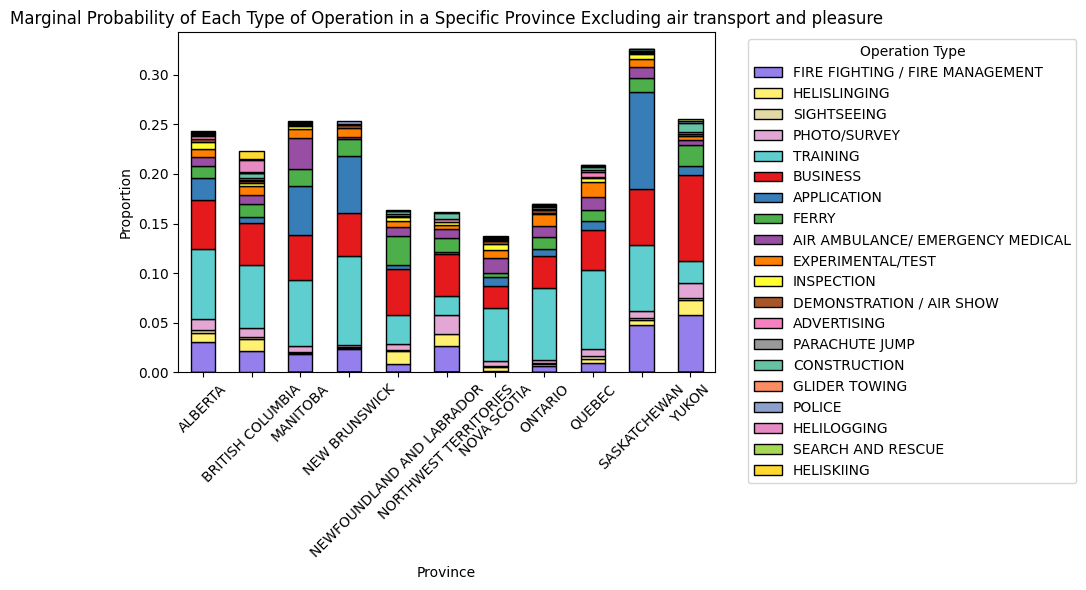

In [20]:
operation_types = pd.DataFrame(province_probabilities['OperationTypeID_DisplayEng'].tolist(),
                               index=province_probabilities.index).fillna(0)

operation_types.index = operation_types.index.str.upper()
operation_types_filtered = operation_types.loc[operation_types.index.intersection(selected_provinces)]
operation_types_filtered = operation_types_filtered.drop(columns=['UNKNOWN', 'OTHER', 'AIR TRANSPORT', 'PLEASURE/TRAVEL'])
    
operation_types_filtered.plot(kind='bar', stacked=True, figsize=(10, 6), color=color_palette, edgecolor='black')
plt.title('Marginal Probability of Each Type of Operation in a Specific Province Excluding air transport and pleasure')
plt.ylabel('Proportion')
plt.xlabel('Province')
plt.xticks(rotation=45)
plt.legend(title='Operation Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
operation_types_filtered.head(11)

,FIRE FIGHTING / FIRE MANAGEMENT,HELISLINGING,SIGHTSEEING,PHOTO/SURVEY,TRAINING,BUSINESS,APPLICATION,FERRY,AIR AMBULANCE/ EMERGENCY MEDICAL,EXPERIMENTAL/TEST,INSPECTION,DEMONSTRATION / AIR SHOW,ADVERTISING,PARACHUTE JUMP,CONSTRUCTION,GLIDER TOWING,POLICE,HELILOGGING,SEARCH AND RESCUE,HELISKIING
ProvinceID_DisplayEng,,,,,,,,,,,,,,,,,,,,
ALBERTA,0.031012,0.009068,0.002539,0.011063,0.071092,0.048966,0.022488,0.011970,0.008886,0.007617,0.007254,0.003627,0.002176,0.001451,0.001451,0.000907,0.000725,0.000363,0.000181,0.0000
BRITISH COLUMBIA,0.021964,0.011876,0.001915,0.008556,0.063977,0.042651,0.005236,0.013153,0.009705,0.009067,0.002682,0.001915,0.000894,0.002299,0.004597,0.000383,0.001405,0.012259,0.000638,0.0083
MANITOBA,0.018182,0.001715,0.001029,0.005146,0.066895,0.045283,0.050086,0.016467,0.031561,0.008576,0.003774,0.001029,0.000686,0.001372,0.001029,0.000686,0.000000,0.000000,0.000000,0.0000
NEW BRUNSWICK,0.023256,0.001292,0.001292,0.001292,0.090439,0.042636,0.058140,0.016796,0.002584,0.009044,0.000000,0.002584,0.001292,0.000000,0.000000,0.000000,0.002584,0.000000,0.000000,0.0000
NEWFOUNDLAND AND LABRADOR,0.008850,0.012979,0.001180,0.005310,0.029499,0.046608,0.003540,0.029499,0.009440,0.005900,0.004130,0.000590,0.001770,0.000000,0.002950,0.000000,0.000590,0.000000,0.001180,0.0000
NORTHWEST TERRITORIES,0.026158,0.012706,0.000000,0.019432,0.018685,0.042601,0.001495,0.014200,0.008969,0.004484,0.002990,0.000000,0.002990,0.000000,0.005979,0.000000,0.000747,0.000000,0.000000,0.0000
NOVA SCOTIA,0.000914,0.004570,0.000914,0.005484,0.053016,0.021938,0.009141,0.004570,0.014625,0.008227,0.005484,0.003656,0.000914,0.000914,0.000914,0.000914,0.000000,0.000000,0.000914,0.0000
ONTARIO,0.005988,0.002108,0.001687,0.003036,0.072109,0.032386,0.006663,0.012145,0.011301,0.012229,0.001181,0.002446,0.001434,0.002024,0.000759,0.001434,0.000590,0.000000,0.000084,0.0000
QUEBEC,0.009904,0.003565,0.002641,0.007131,0.080285,0.040011,0.009375,0.010828,0.013337,0.015186,0.003301,0.001188,0.005414,0.001849,0.002773,0.000924,0.000792,0.000132,0.000660,0.0000


#### Marginal probability of each type of operator type in a specific province

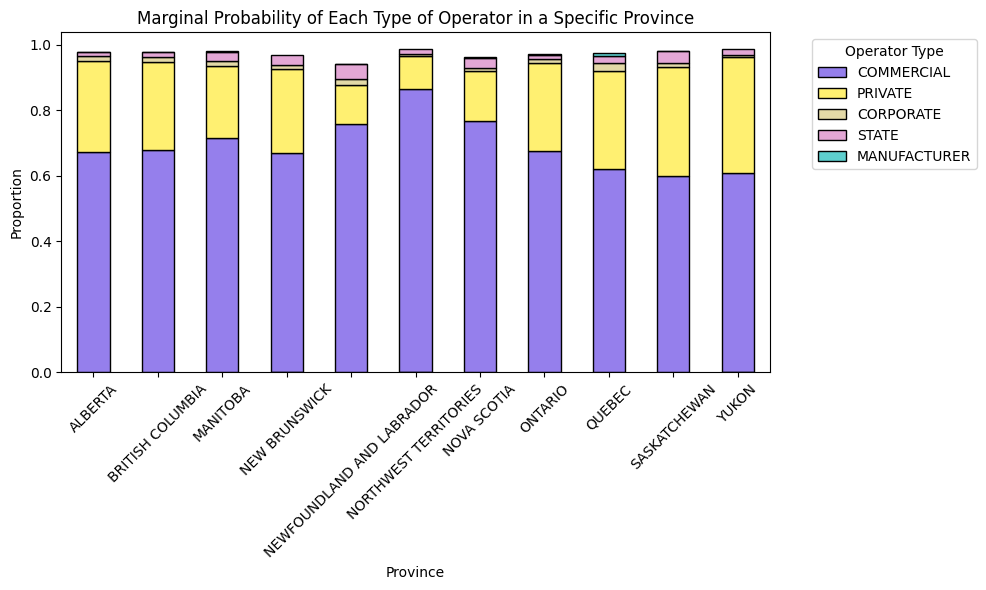

In [41]:
operator_types = pd.DataFrame(province_probabilities['OperatorTypeID_DisplayEng'].tolist(),
                               index=province_probabilities.index).fillna(0)

#Just Canadian provinces
operator_types.index = operator_types.index.str.upper()
operator_types_filtered = operator_types.loc[operator_types.index.intersection(selected_provinces)]

operator_types_filtered = operator_types_filtered.drop(columns=['UNKNOWN', 'OTHER'])
    
#Graph
operator_types_filtered.plot(kind='bar', stacked=True, figsize=(10, 6), color=color_palette, edgecolor='black')
plt.title('Marginal Probability of Each Type of Operator in a Specific Province')
plt.ylabel('Proportion')
plt.xlabel('Province')
plt.xticks(rotation=45)
plt.legend(title='Operator Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
operator_types_filtered.head(11)

,COMMERCIAL,PRIVATE,CORPORATE,STATE,MANUFACTURER
ProvinceID_DisplayEng,,,,,
ALBERTA,0.673192,0.276962,0.016494,0.011238,0.000906
BRITISH COLUMBIA,0.677687,0.270232,0.015828,0.013148,0.000511
MANITOBA,0.715609,0.220926,0.012693,0.029503,0.002058
NEW BRUNSWICK,0.669251,0.257106,0.011628,0.032300,0.000000
NEWFOUNDLAND AND LABRADOR,0.759292,0.117404,0.019469,0.044838,0.001770
NORTHWEST TERRITORIES,0.865471,0.101644,0.005979,0.012706,0.000000
NOVA SCOTIA,0.766910,0.151737,0.010969,0.029250,0.002742
ONTARIO,0.674705,0.268381,0.012310,0.014418,0.001602
QUEBEC,0.621418,0.297636,0.024033,0.024033,0.009111


#### Marginal probability of each aircraft type in a specific province

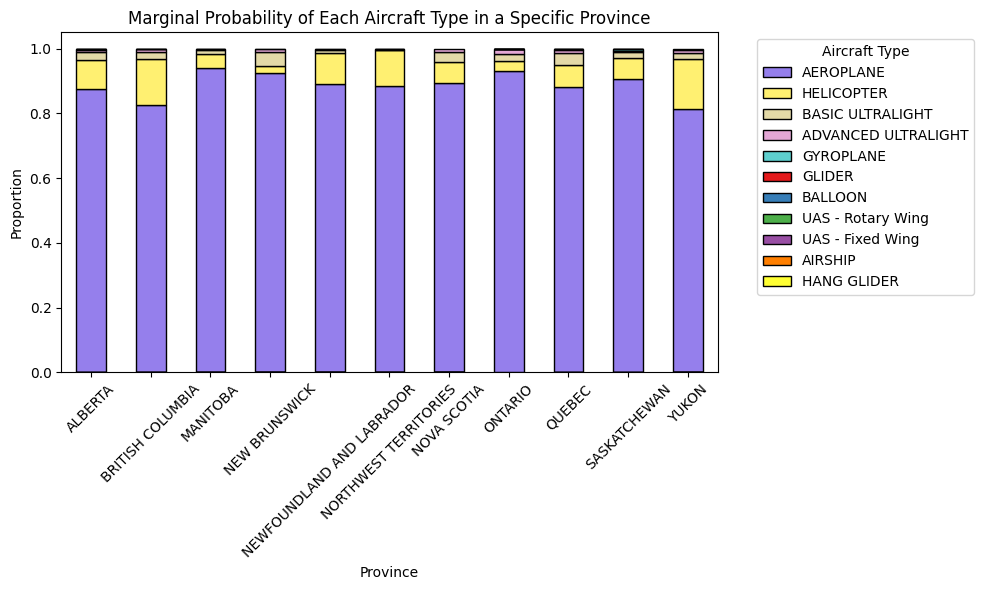

In [26]:
aircraft_types = pd.DataFrame(province_probabilities['AircraftTypeID_DisplayEng'].tolist(),
                              index=province_probabilities.index).fillna(0)

aircraft_types.index = aircraft_types.index.str.upper()
aircraft_types_filtered = aircraft_types.loc[aircraft_types.index.intersection(selected_provinces)]
aircraft_types_filtered = aircraft_types_filtered.drop(columns=['UNKNOWN'])

#Graph
aircraft_types_filtered.plot(kind='bar', stacked=True, figsize=(10, 6), color=color_palette, edgecolor='black')
plt.title('Marginal Probability of Each Aircraft Type in a Specific Province')
plt.ylabel('Proportion')
plt.xlabel('Province')
plt.xticks(rotation=45)
plt.legend(title='Aircraft Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [27]:
aircraft_types_filtered.head(11)

,AEROPLANE,HELICOPTER,BASIC ULTRALIGHT,ADVANCED ULTRALIGHT,GYROPLANE,GLIDER,BALLOON,UAS - Rotary Wing,UAS - Fixed Wing,AIRSHIP,HANG GLIDER
ProvinceID_DisplayEng,,,,,,,,,,,
ALBERTA,0.875476,0.089541,0.025376,0.005982,0.002175,0.000544,0.000544,0.000181,0.000000,0.000000,0.000000
BRITISH COLUMBIA,0.825887,0.142328,0.021956,0.007914,0.000638,0.001021,0.000128,0.000000,0.000000,0.000000,0.000000
MANITOBA,0.940995,0.040823,0.012693,0.003774,0.001372,0.000000,0.000343,0.000000,0.000000,0.000000,0.000000
NEW BRUNSWICK,0.923773,0.021964,0.042636,0.010336,0.001292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NEWFOUNDLAND AND LABRADOR,0.889676,0.097935,0.008260,0.003540,0.000590,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NORTHWEST TERRITORIES,0.884903,0.110613,0.000747,0.000747,0.002242,0.000000,0.000000,0.000747,0.000000,0.000000,0.000000
NOVA SCOTIA,0.893967,0.065814,0.029250,0.010969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ONTARIO,0.929680,0.030438,0.024115,0.012901,0.001265,0.000422,0.000506,0.000253,0.000169,0.000169,0.000084
QUEBEC,0.881685,0.068401,0.034597,0.011488,0.002245,0.000528,0.000528,0.000396,0.000000,0.000000,0.000000


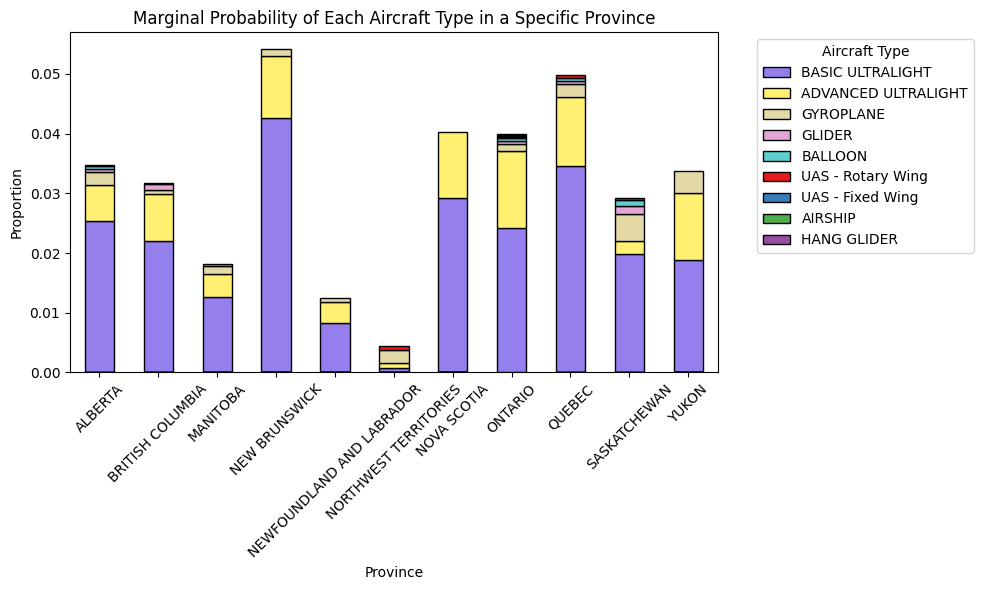

In [28]:
aircraft_types_filtered = aircraft_types_filtered.drop(columns=['AEROPLANE','HELICOPTER'])
aircraft_types_filtered.plot(kind='bar', stacked=True, figsize=(10, 6), color=color_palette, edgecolor='black')
plt.title('Marginal Probability of Each Aircraft Type in a Specific Province')
plt.ylabel('Proportion')
plt.xlabel('Province')
plt.xticks(rotation=45)
plt.legend(title='Aircraft Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Marginal probability of each type of injury in a specific province.

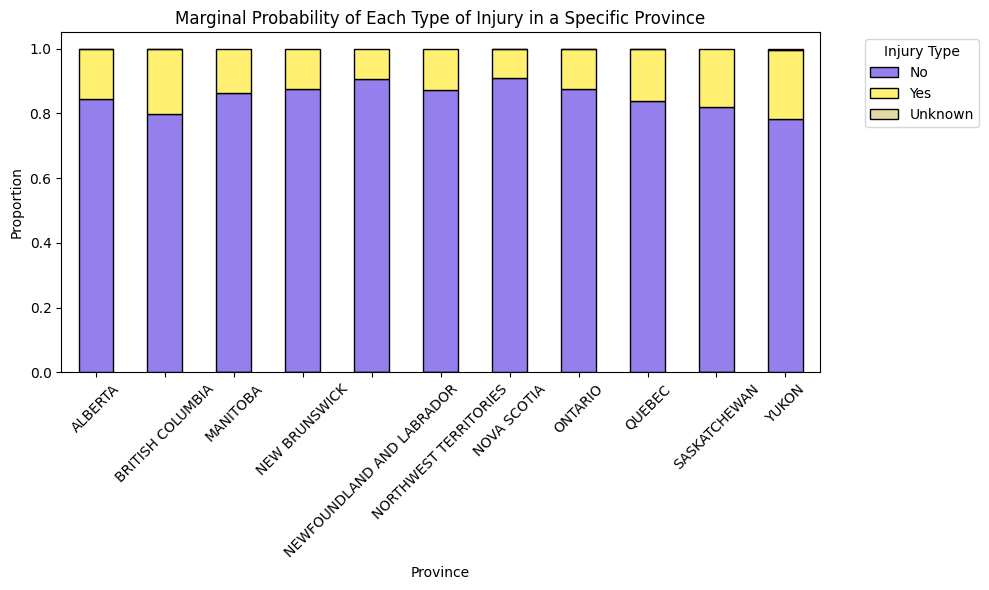

In [30]:
injuries_types = pd.DataFrame(province_probabilities['InjuriesEnum_DisplayEng'].tolist(),
                              index=province_probabilities.index).fillna(0)

injuries_types.index = injuries_types.index.str.upper()
injuries_types_filtered = injuries_types.loc[injuries_types.index.intersection(selected_provinces)]

injuries_types_filtered.plot(kind='bar', stacked=True, figsize=(10, 6), color=color_palette, edgecolor='black')
plt.title('Marginal Probability of Each Type of Injury in a Specific Province')
plt.ylabel('Proportion')
plt.xlabel('Province')
plt.xticks(rotation=45)
plt.legend(title='Injury Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [31]:
injuries_types_filtered.head(11)

,No,Yes,Unknown
ProvinceID_DisplayEng,,,
ALBERTA,0.844843,0.154976,0.000181
BRITISH COLUMBIA,0.796400,0.201302,0.002298
MANITOBA,0.862779,0.137221,0.000000
NEW BRUNSWICK,0.874677,0.125323,0.000000
NEWFOUNDLAND AND LABRADOR,0.906195,0.093805,0.000000
NORTHWEST TERRITORIES,0.870703,0.129297,0.000000
NOVA SCOTIA,0.908592,0.090494,0.000914
ONTARIO,0.873609,0.126307,0.000084
QUEBEC,0.839165,0.160702,0.000132


#### Average age of aircraft involved in incidents in a specific province.

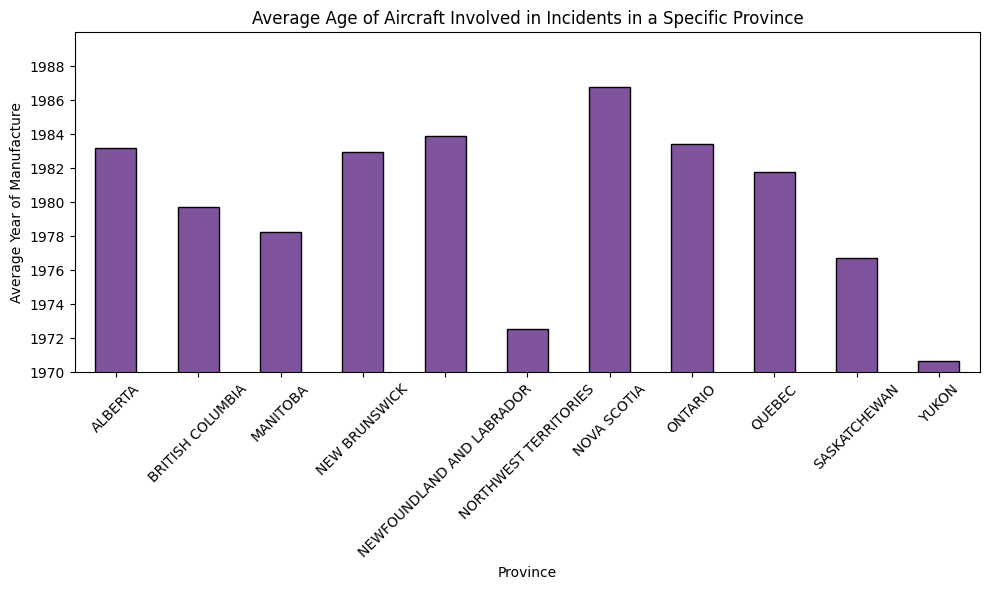

In [33]:
# Filtrar la columna de edad promedio de aeronaves
aircraft_age = province_probabilities['YearOfManuf']

# Filtrar por provincias seleccionadas
aircraft_age.index = aircraft_age.index.str.upper()
aircraft_age_filtered = aircraft_age.loc[aircraft_age.index.intersection(selected_provinces)]

# Graficar
aircraft_age_filtered.plot(kind='bar', figsize=(10, 6), color='#80549c', edgecolor='black')
plt.title('Average Age of Aircraft Involved in Incidents in a Specific Province')
plt.ylabel('Average Year of Manufacture')
plt.xlabel('Province')
plt.xticks(rotation=45)
plt.ylim(1970, 1990)  
plt.yticks(range(1970, 1990, 2))
plt.tight_layout()
plt.show()


In [34]:
aircraft_age_filtered_df = aircraft_age_filtered.reset_index()
aircraft_age_filtered_df.head(11)

,ProvinceID_DisplayEng,YearOfManuf
0,ALBERTA,1983.192858
1,BRITISH COLUMBIA,1979.734746
2,MANITOBA,1978.250086
3,NEW BRUNSWICK,1982.985788
4,NEWFOUNDLAND AND LABRADOR,1983.882006
5,NORTHWEST TERRITORIES,1972.576981
6,NOVA SCOTIA,1986.778793
7,ONTARIO,1983.407589
8,QUEBEC,1981.783573
9,SASKATCHEWAN,1976.752814


### Conditional probabilities 

In [45]:
import seaborn as sns

#### Conditional Probability: Number of Engines vs Damage Level

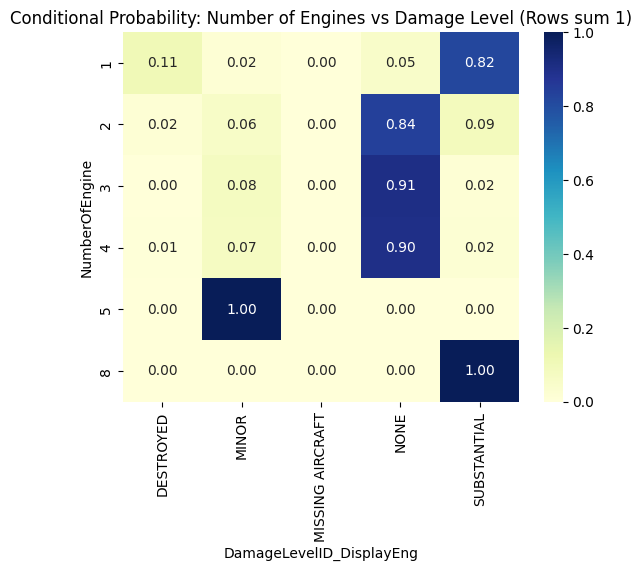

In [47]:
filtered_df = df[df['NumberOfEngine'].isin([1, 2, 3, 4, 5, 6, 7, 8])]
filtered_df = filtered_df[filtered_df['DamageLevelID_DisplayEng'] != "UNKNOWN"]

joint_prob = pd.crosstab(
    filtered_df['NumberOfEngine'],
    filtered_df['DamageLevelID_DisplayEng'],
    normalize='index'    
)
#Heatmap
sns.heatmap(joint_prob, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Conditional Probability: Number of Engines vs Damage Level (Rows sum 1)")
plt.show()

####  Conditional Probability: OperatorType vs Damage Level

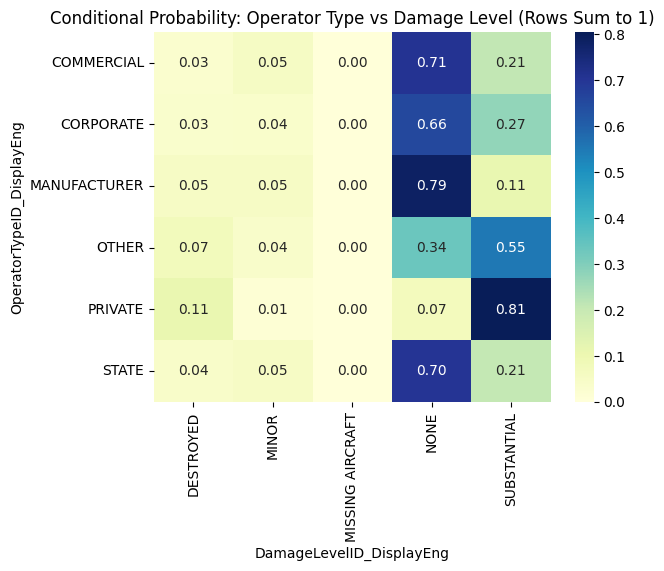

In [40]:
filtered_df = df[df["OperatorTypeID_DisplayEng"] != "UNKNOWN"]
filtered_df = filtered_df[filtered_df['DamageLevelID_DisplayEng'] != "UNKNOWN"]
joint_prob = pd.crosstab(
    filtered_df['OperatorTypeID_DisplayEng'],
    filtered_df['DamageLevelID_DisplayEng'],
    normalize='index'  
)

#Heatmap
sns.heatmap(joint_prob, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Conditional Probability: Operator Type vs Damage Level (Rows Sum to 1)")
plt.show()

#### Conditional Probability: Top 10 Aircraft Makes vs Damage Level

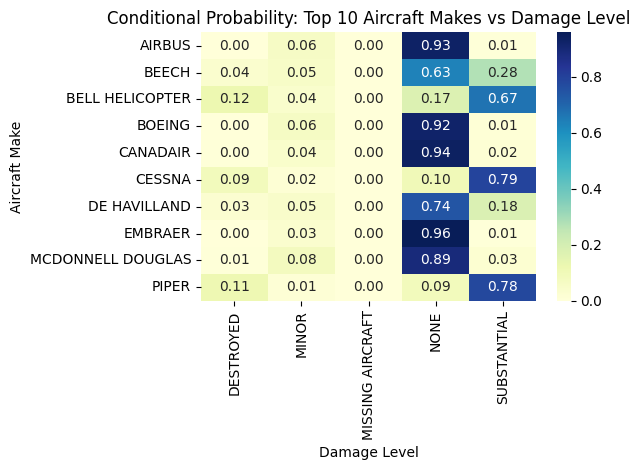

In [42]:
#10 most frecuent fabricants
top_10_aircraft_makes = (
    df['AircraftMakeID_DisplayEng']
    .value_counts()
    .head(10)
    .index
)

filtered_df = df[
    (df['AircraftMakeID_DisplayEng'].isin(top_10_aircraft_makes)) &
    (df['AircraftMakeID_DisplayEng'] != "UNKNOWN MANUFACTURER")
]
filtered_df = filtered_df[filtered_df['DamageLevelID_DisplayEng'] != "UNKNOWN"]

joint_prob = pd.crosstab(
    filtered_df['AircraftMakeID_DisplayEng'],
    filtered_df['DamageLevelID_DisplayEng'],
    normalize='index'
)

sns.heatmap(joint_prob, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Conditional Probability: Top 10 Aircraft Makes vs Damage Level")
plt.ylabel("Aircraft Make")
plt.xlabel("Damage Level")
plt.tight_layout()
plt.show()


#### Conditional Probability: Top 10 Aircraft Makes vs Injuries

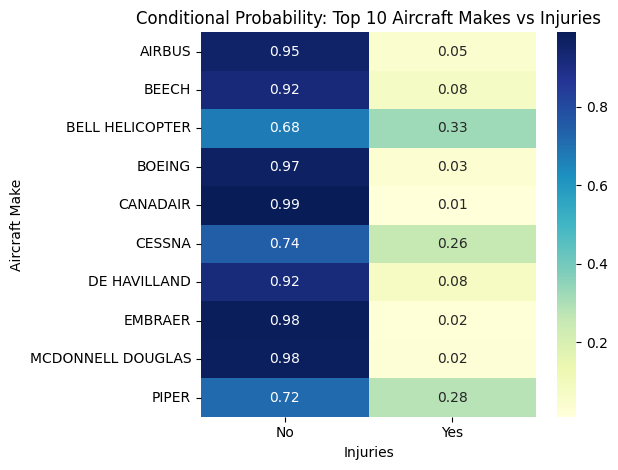

In [44]:
#10 most frecuent fabricants
top_10_aircraft_makes = (
    df['AircraftMakeID_DisplayEng']
    .value_counts()
    .head(10)
    .index
)

filtered_df = df[
    (df['AircraftMakeID_DisplayEng'].isin(top_10_aircraft_makes)) &
    (df['AircraftMakeID_DisplayEng'] != "UNKNOWN MANUFACTURER")
]
filtered_df = filtered_df[filtered_df['DamageLevelID_DisplayEng'] != "UNKNOWN"]
filtered_df = filtered_df[filtered_df["InjuriesEnum_DisplayEng"] != "Unknown"]

joint_prob = pd.crosstab(
    filtered_df['AircraftMakeID_DisplayEng'],
    filtered_df['InjuriesEnum_DisplayEng'],
    normalize='index'
)

sns.heatmap(joint_prob, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Conditional Probability: Top 10 Aircraft Makes vs Injuries")
plt.ylabel("Aircraft Make")
plt.xlabel("Injuries")
plt.tight_layout()
plt.show()

#### Conditional Probability: Top 10 Commertial organizations vs Damage Level

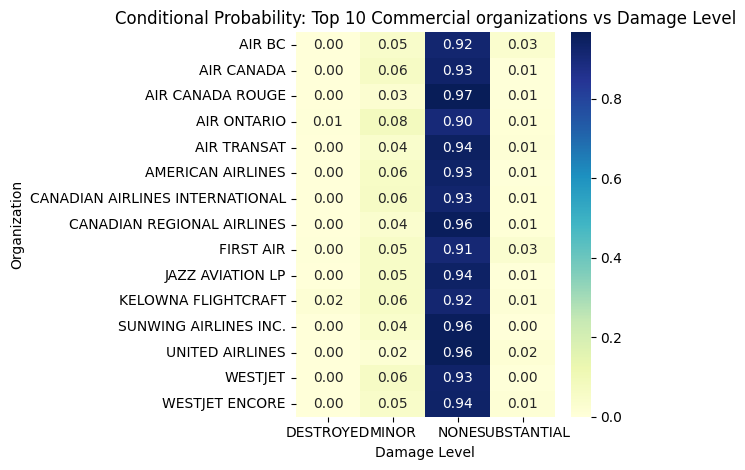

In [50]:

filtered_df = df[
    (df['OperatorTypeID_DisplayEng'] == "COMMERCIAL") &
    (df['OrganizationID_DisplayEng'] != "UNKNOWN")
]
filtered_df = filtered_df[filtered_df['DamageLevelID_DisplayEng'] != "UNKNOWN"]
top_10_organizations = (
    filtered_df['OrganizationID_DisplayEng']
    .value_counts()
    .head(15)
    .index
)

filtered_df = filtered_df[
    (filtered_df['OrganizationID_DisplayEng'].isin(top_10_organizations))
]
joint_prob = pd.crosstab(
    filtered_df['OrganizationID_DisplayEng'],
    filtered_df['DamageLevelID_DisplayEng'],
    normalize='index'
)

sns.heatmap(joint_prob, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Conditional Probability: Top 10 Commercial organizations vs Damage Level")
plt.ylabel("Organization")
plt.xlabel("Damage Level")
plt.tight_layout()
plt.show()

### Binomial probability to analyze injuries

In [48]:
from scipy.stats import binom
from scipy.special import gammaln

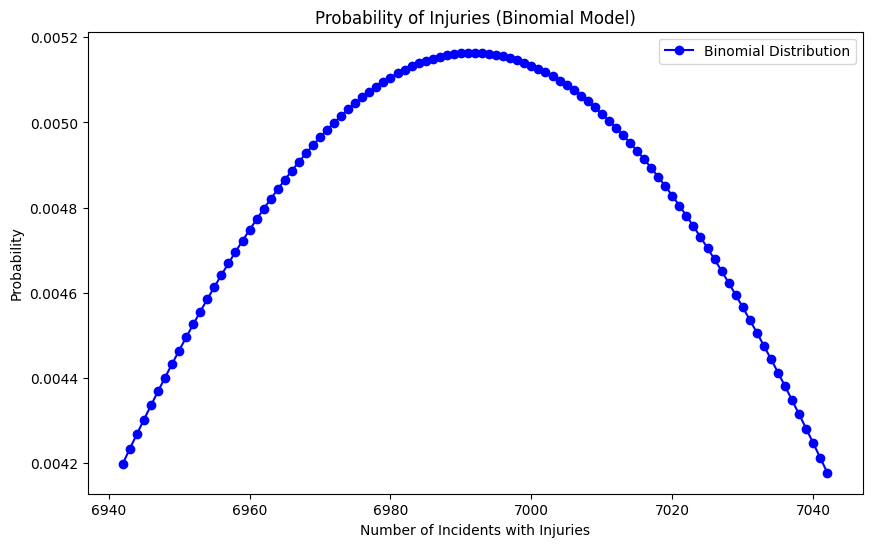

In [49]:
#Probability of injuries
p_injuries = (df['InjuriesEnum_DisplayEng'] == 'Yes').mean()

#Total of accidents/incidents
n_incidents = len(df)

expected_injuries = int(n_incidents * p_injuries)
lower_bound = max(0, expected_injuries - 50)  
upper_bound = min(n_incidents, expected_injuries + 50)  
x = np.arange(lower_bound, upper_bound + 1)

#Generating a binomial distribution
binomial_probs = binom.pmf(x, n_incidents, p_injuries)

#Graph
plt.figure(figsize=(10, 6))
plt.plot(x, binomial_probs, 'b-', marker='o', label='Binomial Distribution')
plt.title('Probability of Injuries (Binomial Model)')
plt.xlabel('Number of Incidents with Injuries')
plt.ylabel('Probability')
plt.legend()
plt.show()


In [50]:
print(f"Number of injuries: {(df['InjuriesEnum_DisplayEng'] == 'Yes').sum()}")
print(f"Injuries probability: {p_injuries}")
print(f"Total number of occurrences: {n_incidents}")

Number of injuries: 6992
Injuries probability: 0.14630369734887322
Total number of occurrences: 47791


We can find the probabilities
$f(x) = \binom{n}{x} p^x (1 - p)^{n - x}$ , 
$\binom{n}{x} = \frac{n!}{x! (n - x)!}$

##### Probability 0 of 10 occurrences have injuries:
$ f(0) = \binom{10}{0} p^0 (1 - p)^{10 - 0} $

##### Probability 2 of 10 occurrences have injuries:
$ f(2) = \binom{10}{2} p^{2} (1 - p)^{10 - 2} $

**...**
##### Probability 10 of 10 occurrences have injuries:
$f(10) = \binom{10}{10} p^{10} (1 - p)^{10 - 10}$


In [52]:
n_occurrences = 10
def binomial_log_pmf(x, n, p):
    log_prob = (
        gammaln(n + 1) - gammaln(x + 1) - gammaln(n - x + 1) 
        + x * np.log(p)  # Log(p^x)
        + (n - x) * np.log(1 - p)  # Log((1-p)^(n-x))
    )
    return np.exp(log_prob) 

for x in range(0, n_occurrences + 1):
    prob = binomial_log_pmf(x, n_occurrences, p_injuries)
    print(f"Probability of {x} injuries in {n_occurrences} occurrences: {prob:.10}")

Probability of 0 injuries in 10 occurrences: 0.2056051577
Probability of 1 injuries in 10 occurrences: 0.352359436
Probability of 2 injuries in 10 occurrences: 0.2717379665
Probability of 3 injuries in 10 occurrences: 0.1241855184
Probability of 4 injuries in 10 occurrences: 0.03724439331
Probability of 5 injuries in 10 occurrences: 0.007659387673
Probability of 6 injuries in 10 occurrences: 0.001093867468
Probability of 7 injuries in 10 occurrences: 0.000107121972
Probability of 8 injuries in 10 occurrences: 6.884330759e-06
Probability of 9 injuries in 10 occurrences: 2.621809394e-07
Probability of 10 injuries in 10 occurrences: 4.493171716e-09


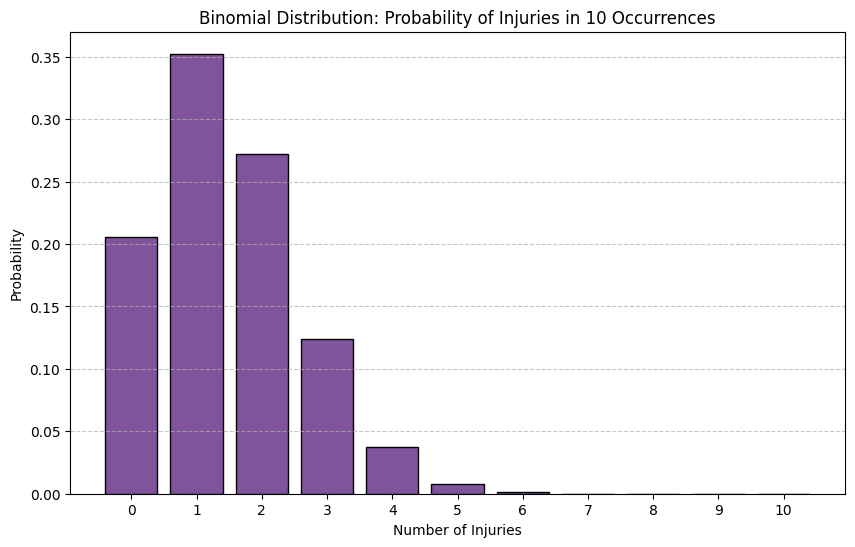

In [53]:
x_values = list(range(0, n_occurrences + 1))
probabilities = [binomial_log_pmf(x, n_occurrences, p_injuries) for x in x_values]

plt.figure(figsize=(10, 6))
plt.bar(x_values, probabilities, color='#80549c', edgecolor='black')
plt.title('Binomial Distribution: Probability of Injuries in 10 Occurrences')
plt.xlabel('Number of Injuries')
plt.ylabel('Probability')
plt.xticks(x_values)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Finding the Distribution of Aircraft Age

In [57]:
from scipy.stats import norm, expon, gamma, lognorm, beta, weibull_min, uniform

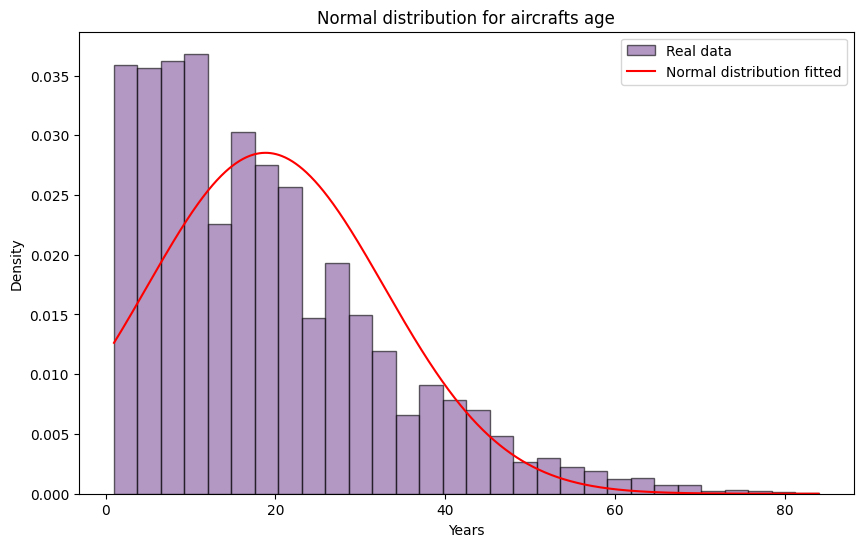

In [59]:
#Calculating age of aircrafts
df['AircraftAge'] = pd.to_datetime(df['OccDate']).dt.year - df['YearOfManuf']
df_filtered = df[df['AircraftAge'] > 0]

#Fitting a normal distribution
mean_age = df_filtered['AircraftAge'].mean()
std_age = df_filtered['AircraftAge'].std()

x = np.linspace(df_filtered['AircraftAge'].min(), df_filtered['AircraftAge'].max(), 1000)
pdf = norm.pdf(x, mean_age, std_age)

#Graph
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['AircraftAge'], bins=30, density=True, alpha=0.6, color='#80549c', edgecolor='black', label='Real data')
plt.plot(x, pdf, 'r-', label='Normal distribution fitted')
plt.title('Normal distribution for aircrafts age')
plt.xlabel('Years')
plt.ylabel('Density')
plt.legend()
plt.show()


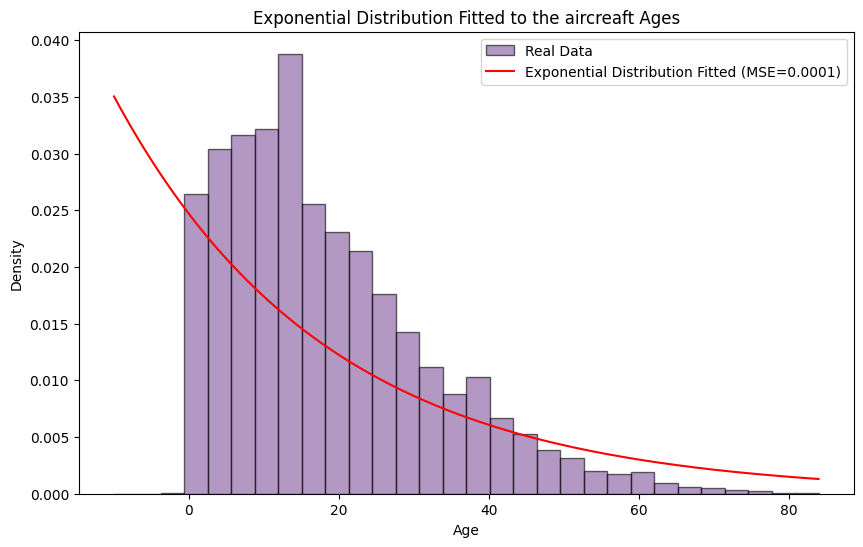

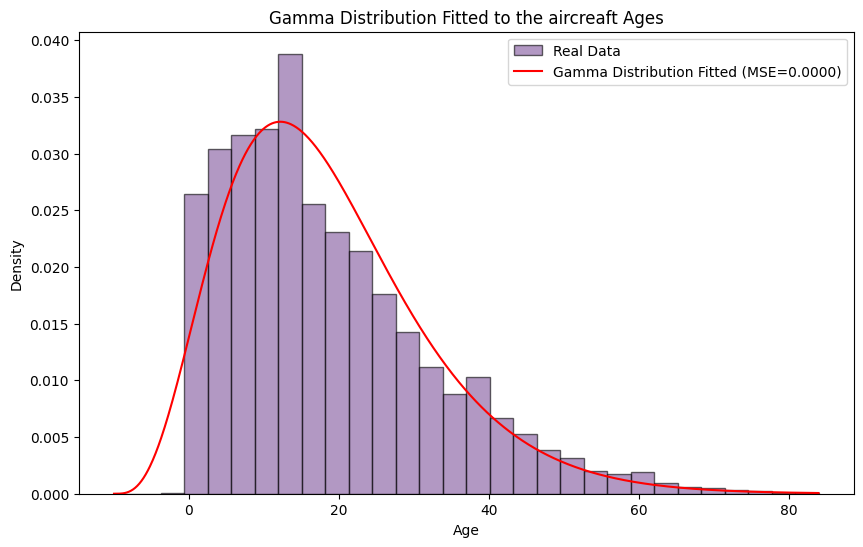

C:\Users\camii\Documents\U\Term 1\Term 1\Data Analytics\Project\Airplane_Accidents_Analytics\venv\Lib\site-packages\scipy\stats\_continuous_distns.py:6617: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


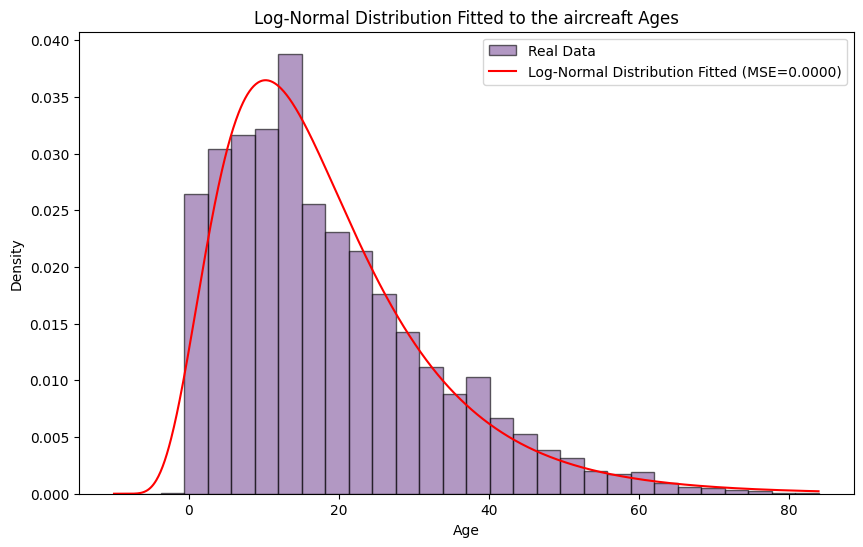

C:\Users\camii\Documents\U\Term 1\Term 1\Data Analytics\Project\Airplane_Accidents_Analytics\venv\Lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


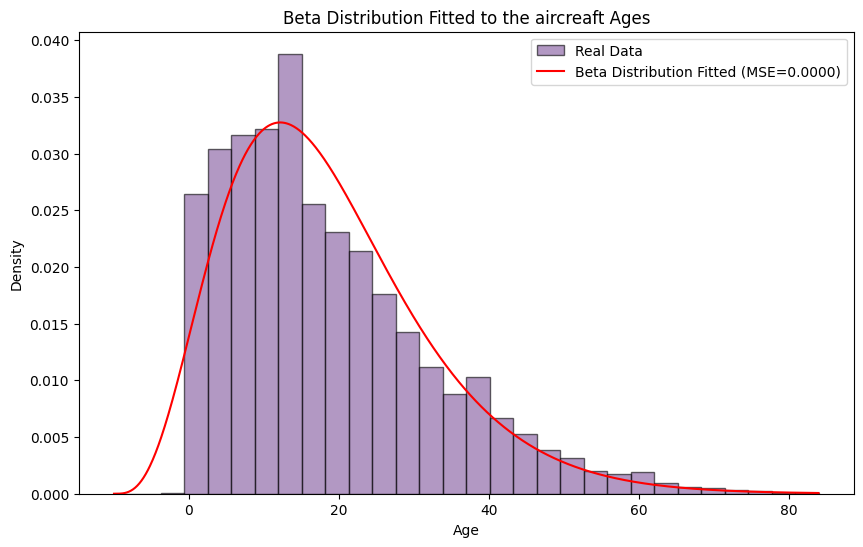

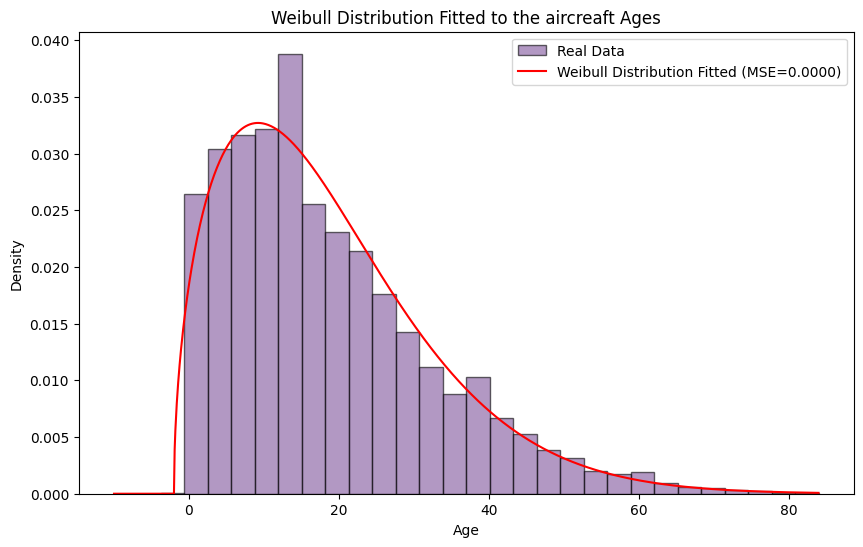

Best fit: Weibull Distribution
Params: (1.515455021262854, -2.0016440904961446, 22.84866655814801)


In [63]:
aircraft_ages = df['AircraftAge'] 

#Setting a range
x = np.linspace(aircraft_ages.min(), aircraft_ages.max(), 1000)

#Dict to store results
results = {}

def fit_and_plot_distribution(dist, dist_name):

    params = dist.fit(aircraft_ages)
    fitted_pdf = dist.pdf(x, *params)

    histogram_values, bin_edges = np.histogram(aircraft_ages, bins=30, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mse = np.mean((dist.pdf(bin_centers, *params) - histogram_values)**2)
    
    results[dist_name] = {'params': params, 'mse': mse}

    plt.figure(figsize=(10, 6))
    plt.hist(aircraft_ages, bins=30, density=True, alpha=0.6, color='#80549c', edgecolor='black', label='Real Data')
    plt.plot(x, fitted_pdf, 'r-', label=f'{dist_name} Fitted (MSE={mse:.4f})')
    plt.title(f'{dist_name} Fitted to the aircreaft Ages')
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

#Fitting each distribution
fit_and_plot_distribution(expon, "Exponential Distribution")
fit_and_plot_distribution(gamma, "Gamma Distribution")
fit_and_plot_distribution(lognorm, "Log-Normal Distribution")
fit_and_plot_distribution(beta, "Beta Distribution")
fit_and_plot_distribution(weibull_min, "Weibull Distribution")

#Compraring results
best_fit = min(results, key=lambda k: results[k]['mse'])
print("Best fit:", best_fit)
print("Params:", results[best_fit]['params'])



In [58]:
results_df = pd.DataFrame(results)
results_df.head()

,Exponential Distribution,Gamma Distribution,Log-Normal Distribution,Beta Distribution,Weibull Distribution
params,"(-10.0, 28.547550794082568)","(4.492622262981321, -10.020182593073503, 6.358...","(0.47755920822198145, -10.224533127597377, 25....","(4.457882567322187, 5211.632900783439, -10.040...","(1.513721357872897, -2.0016295533185895, 22.85..."
mse,0.000127,0.000015,0.000011,0.000015,0.00001


#### Variance and Standard Deviation of Manufacturing Years

In [60]:
variance = df['YearOfManuf'].var()
std_dev = df['YearOfManuf'].std()
print(f"Variance: {variance}, Standard Deviation: {std_dev}")

Variance: 282.165846029673, Standard Deviation: 16.797792891617426


#### Distribution of Incident Times

In [62]:
from datetime import datetime
from sklearn.metrics import mean_squared_error

Best fitting distribution: Normal
Mean Squared Errors (MSE) for distributions:
Uniform: 0.000000
Normal: 0.000000
Exponential: 0.000000
Gamma: 0.000000
Weibull: 0.000000


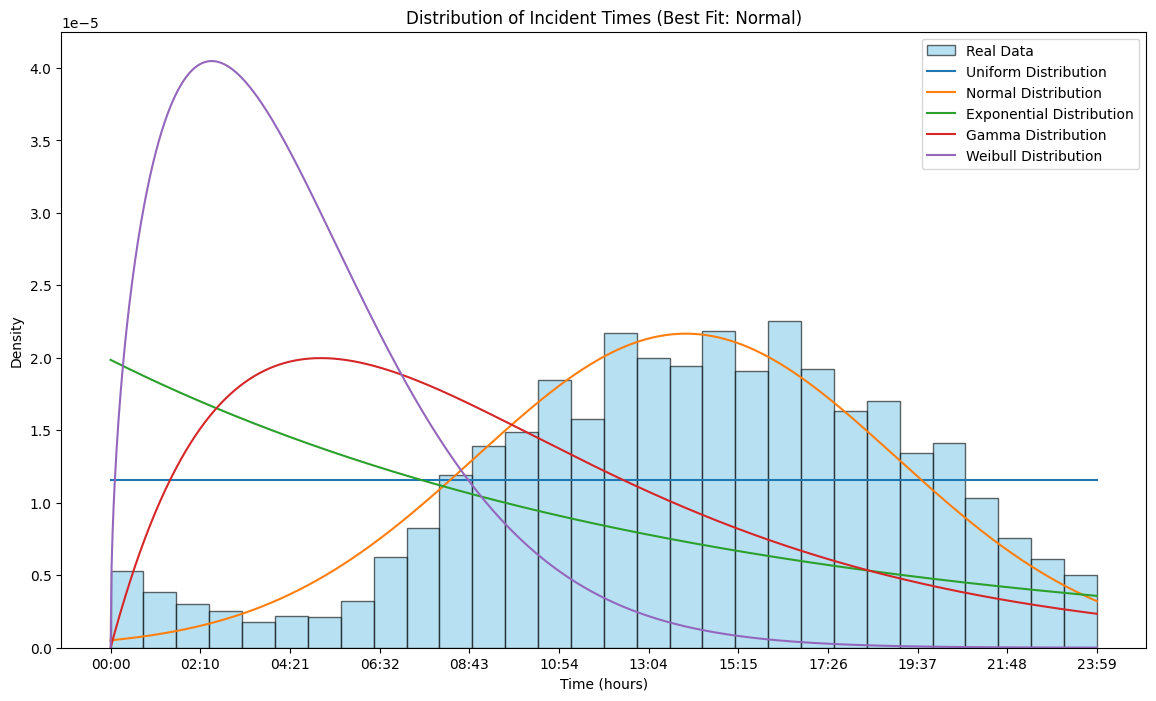

In [63]:
#function to convert OccTime to seconds of the day
def time_to_seconds(time_str):
    try:
        time_obj = datetime.strptime(time_str, '%H:%M:%S')
        return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second
    except ValueError:
        return np.nan

df['TimeInSeconds'] = df['OccTime'].apply(time_to_seconds)
df_time_filtered = df[df['TimeInSeconds'].notna()].copy()

#Creating a continuous range for the seconds of the day
x_range = np.linspace(df_time_filtered['TimeInSeconds'].min(), df_time_filtered['TimeInSeconds'].max(), 1000)

#Statistics for distribution calculations
a = df_time_filtered['TimeInSeconds'].min()  # Minimum time in seconds
b = df_time_filtered['TimeInSeconds'].max()  # Maximum time in seconds
mean_time = df_time_filtered['TimeInSeconds'].mean()  # Mean time
std_time = df_time_filtered['TimeInSeconds'].std()  # Standard deviation of time

#distributions
distributions = {
    "Uniform": uniform.pdf(x_range, loc=a, scale=b - a),
    "Normal": norm.pdf(x_range, loc=mean_time, scale=std_time),
    "Exponential": expon.pdf(x_range, loc=df_time_filtered['TimeInSeconds'].min(), scale=df_time_filtered['TimeInSeconds'].mean()),
    "Gamma": gamma.pdf(x_range, a=2, loc=df_time_filtered['TimeInSeconds'].min(), scale=std_time),
    "Weibull": weibull_min.pdf(x_range, c=1.5, loc=df_time_filtered['TimeInSeconds'].min(), scale=std_time),
}

#MSE for each distribution
mse_results = {}
for name, pdf in distributions.items():
    hist, bin_edges = np.histogram(df_time_filtered['TimeInSeconds'], bins=30, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Calculate the bin centers
    mse_results[name] = mean_squared_error(hist, np.interp(bin_centers, x_range, pdf))  # Interpolate PDFs to bin centers

#esults
best_fit = min(mse_results, key=mse_results.get)
print("Best fitting distribution:", best_fit)
print("Mean Squared Errors (MSE) for distributions:")
for name, mse in mse_results.items():
    print(f"{name}: {mse:.6f}")

#Functions to convert seconds into hours and minutes format (HH:MM)
def seconds_to_hours(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    return f"{int(hours):02}:{int(minutes):02}"  # Format as HH:MM

#Creating custom labels for the X-axis (time labels)
x_ticks = np.linspace(df_time_filtered['TimeInSeconds'].min(), df_time_filtered['TimeInSeconds'].max(), 12)  # Increase number of labels
x_labels = [seconds_to_hours(tick) for tick in x_ticks]

#Plotting the histogram and PDFs
plt.figure(figsize=(14, 8))  # Make the plot wider for better readability
plt.hist(df_time_filtered['TimeInSeconds'], bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Real Data')
for name, pdf in distributions.items():
    plt.plot(x_range, pdf, label=f"{name} Distribution")
plt.title(f'Distribution of Incident Times (Best Fit: {best_fit})')
plt.xlabel('Time (hours)')
plt.ylabel('Density')
plt.xticks(ticks=x_ticks, labels=x_labels)  # Apply custom time labels
plt.legend()
plt.show()


#### Bayes theorem
##### Posterior Probability of Injuries Given Incident Type

In [65]:
#Prior probabilities
p_injuries = df['InjuriesEnum_DisplayEng'].value_counts(normalize=True)['Yes']
p_no_injuries = df['InjuriesEnum_DisplayEng'].value_counts(normalize=True)['No']

#Likelihood: P(Incident_Type | Injuries) and P(Incident_Type | No Injuries)
likelihood = pd.crosstab(df['OccTypeID_DisplayEng'], df['InjuriesEnum_DisplayEng'], normalize='columns')

#Evidence: P(Incident_Type)
evidence = df['OccTypeID_DisplayEng'].value_counts(normalize=True)

#Posterior probabilities: P(Injuries | Incident_Type)
posterior_injuries = (likelihood['Yes'] * p_injuries) / evidence
posterior_no_injuries = (likelihood['No'] * p_no_injuries) / evidence

#Display results
print("Posterior probabilities of injuries given incident type:")
print(posterior_injuries)
print("\nPosterior probabilities of no injuries given incident type:")
print(posterior_no_injuries)


Posterior probabilities of injuries given incident type:
OccTypeID_DisplayEng
ACCIDENT    0.331184
INCIDENT    0.016660
dtype: float64

Posterior probabilities of no injuries given incident type:
OccTypeID_DisplayEng
ACCIDENT    0.667648
INCIDENT    0.983234
dtype: float64


##### Inference of Safest Aircraft Type 

In [67]:
#Prior probabilities: P(Aircraft)
p_aircraft = df['AircraftTypeID_DisplayEng'].value_counts(normalize=True)

#Likelihood: P(Substantial Damage | Aircraft)
likelihood_damage = pd.crosstab(df['AircraftTypeID_DisplayEng'], df['DamageLevelID_DisplayEng'], normalize='index')['SUBSTANTIAL']

#Evidence: P(Substantial Damage)
p_substantial_damage = df['DamageLevelID_DisplayEng'].value_counts(normalize=True)['SUBSTANTIAL']

#Posterior probabilities: P(Safe Aircraft | Substantial Damage)
posterior_aircraft_safe = (likelihood_damage * p_aircraft) / p_substantial_damage

#Display results
print("Posterior probabilities of aircraft type safety given substantial damage:")
print(posterior_aircraft_safe)


Posterior probabilities of aircraft type safety given substantial damage:
AircraftTypeID_DisplayEng
ADVANCED ULTRALIGHT    0.020019
AEROPLANE              0.800406
AIRSHIP                0.000120
BALLOON                0.000299
BASIC ULTRALIGHT       0.050795
GLIDER                 0.000956
GYROPLANE              0.003526
HANG GLIDER            0.000060
HELICOPTER             0.123342
UAS - Fixed Wing       0.000000
UAS - Rotary Wing      0.000359
UNKNOWN                0.000120
dtype: float64


#### Bayesian Analysis of Severe Incidents by Region

In [69]:
#Filter the dataframe to include only the selected provinces
filtered_df = df[df['ProvinceID_DisplayEng'].isin(selected_provinces)]

#Prior probabilities: P(Severe Incident)
p_severe_incidents = filtered_df['DamageLevelID_DisplayEng'].value_counts(normalize=True)['SUBSTANTIAL']

#Likelihood: P(Region | Severe Incident)
likelihood_region = pd.crosstab(
    filtered_df['ProvinceID_DisplayEng'],
    filtered_df['DamageLevelID_DisplayEng'],
    normalize='columns'
)['SUBSTANTIAL']

#Evidence: P(Region)
p_region = filtered_df['ProvinceID_DisplayEng'].value_counts(normalize=True)

#Posterior probabilities: P(Severe Incident | Region)
posterior_severe_by_region = (likelihood_region * p_severe_incidents) / p_region

#Display results
print("Posterior probabilities of severe incidents by selected provinces:")
print(posterior_severe_by_region)

Posterior probabilities of severe incidents by selected provinces:
ProvinceID_DisplayEng
ALBERTA                      0.370310
BRITISH COLUMBIA             0.379627
MANITOBA                     0.408576
NEW BRUNSWICK                0.334625
NEWFOUNDLAND AND LABRADOR    0.206490
NORTHWEST TERRITORIES        0.352018
NOVA SCOTIA                  0.192870
ONTARIO                      0.354300
QUEBEC                       0.407632
SASKATCHEWAN                 0.550203
YUKON                        0.592871
dtype: float64


#### Expected Damage Level by Aircraft Weight

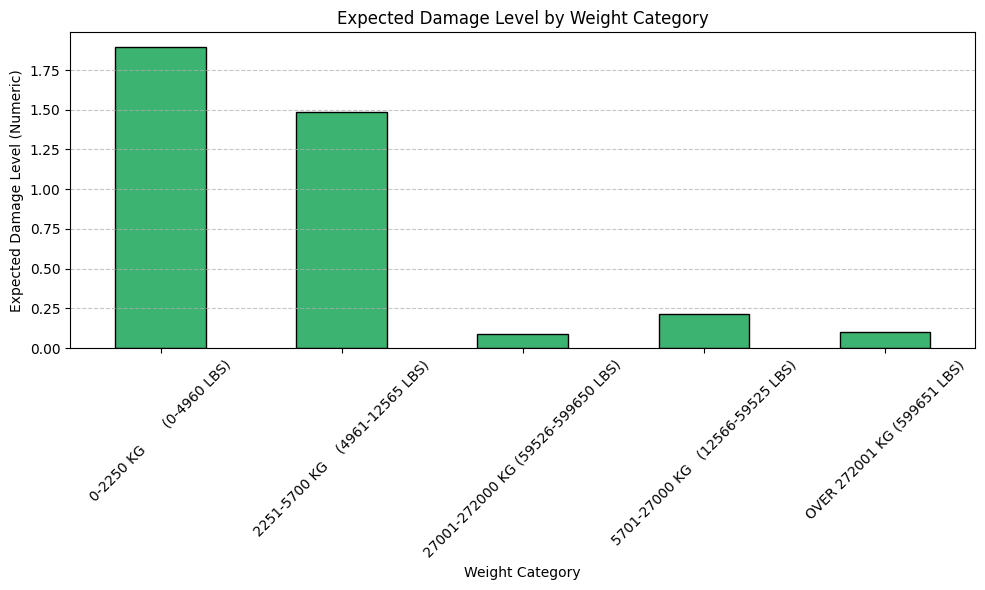

In [69]:
damage_mapping = {'NONE': 0, 'MINOR': 1, 'SUBSTANTIAL': 2}
df['DamageLevelNumeric'] = df['DamageLevelID_DisplayEng'].map(damage_mapping)
filtered_df = df[df["WeightCategoryID_DisplayEng"] != "UNKNOWN"]

expected_damage = filtered_df.groupby('WeightCategoryID_DisplayEng')['DamageLevelNumeric'].mean()

plt.figure(figsize=(10, 6))
expected_damage.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Expected Damage Level by Weight Category')
plt.ylabel('Expected Damage Level (Numeric)')
plt.xlabel('Weight Category')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Expected Aircraft Age by Operation Type

OperationTypeID_DisplayEng
ADVERTISING                         13.913978
AIR AMBULANCE/ EMERGENCY MEDICAL    24.591398
AIR TRANSPORT                       16.693142
APPLICATION                         20.001311
BUSINESS                            17.323699
CONSTRUCTION                        13.530000
DEMONSTRATION / AIR SHOW            23.053763
EXPERIMENTAL/TEST                   14.799136
FERRY                               19.030794
FIRE FIGHTING / FIRE MANAGEMENT     30.958060
GLIDER TOWING                       33.111111
HELILOGGING                         29.690000
HELISKIING                          19.753846
HELISLINGING                        23.306338
INSPECTION                          19.084507
PARACHUTE JUMP                      41.014085
PHOTO/SURVEY                        22.905775
PLEASURE/TRAVEL                     22.868048
POLICE                              14.861111
SEARCH AND RESCUE                   24.764706
SIGHTSEEING                         29.545455
TRAININ

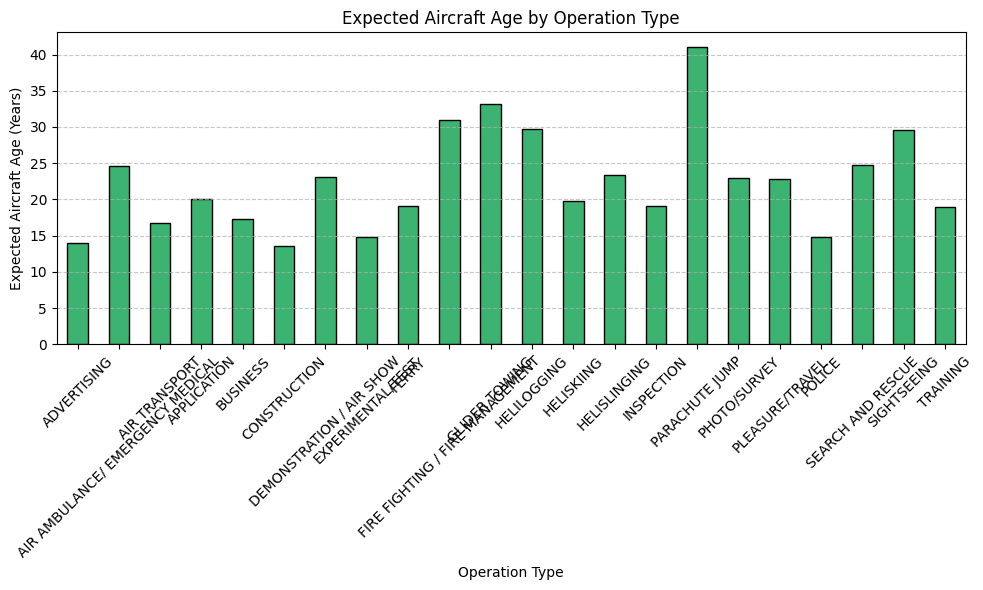

In [73]:
#Filtering out unknown and other operation types
filtered_df = df[(df["OperationTypeID_DisplayEng"] != "UNKNOWN") & (df["OperationTypeID_DisplayEng"] != "OTHER")].copy()

#Calculate aircraft age 
filtered_df.loc[:, 'AircraftAge'] = pd.to_datetime(filtered_df['OccDate']).dt.year - filtered_df['YearOfManuf']

#Calculating the expected aircraft age for each operation type
expected_age = filtered_df.groupby('OperationTypeID_DisplayEng')['AircraftAge'].mean()
print(expected_age)

#Plotting
plt.figure(figsize=(10, 6))
expected_age.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Expected Aircraft Age by Operation Type')
plt.ylabel('Expected Aircraft Age (Years)')
plt.xlabel('Operation Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

####  Expected Number of Injuries by Aircraft Type

AircraftTypeID_DisplayEng
ADVANCED ULTRALIGHT    0.388175
AEROPLANE              0.122641
AIRSHIP                0.500000
BALLOON                0.823529
BASIC ULTRALIGHT       0.558454
GLIDER                 0.458333
GYROPLANE              0.436620
HANG GLIDER            1.000000
HELICOPTER             0.279976
UAS - Fixed Wing       0.000000
UAS - Rotary Wing      0.111111
Name: InjuryNumeric, dtype: float64


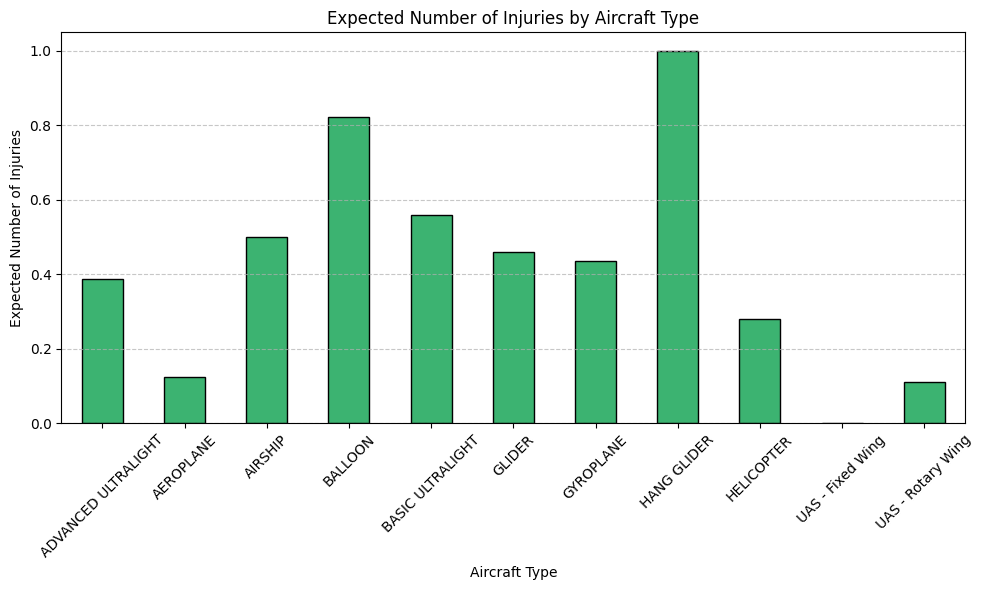

In [67]:
#Injuries to numeric values
injury_mapping = {'No': 0, 'Yes': 1}
filtered_df = df[df["AircraftTypeID_DisplayEng"] != "UNKNOWN"].copy()
filtered_df['InjuryNumeric'] = filtered_df['InjuriesEnum_DisplayEng'].map(injury_mapping)

#Calculating the expected number of injuries for each aircraft type
expected_injuries = filtered_df.groupby('AircraftTypeID_DisplayEng')['InjuryNumeric'].mean()
print(expected_injuries)

#Plotting
plt.figure(figsize=(10, 6))
expected_injuries.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Expected Number of Injuries by Aircraft Type')
plt.ylabel('Expected Number of Injuries')
plt.xlabel('Aircraft Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Expected Damage Level by Operator Type

OperatorTypeID_DisplayEng
COMMERCIAL      0.487933
CORPORATE       0.605926
MANUFACTURER    0.288288
PRIVATE         1.827970
STATE           0.483061
Name: DamageLevelNumeric, dtype: float64


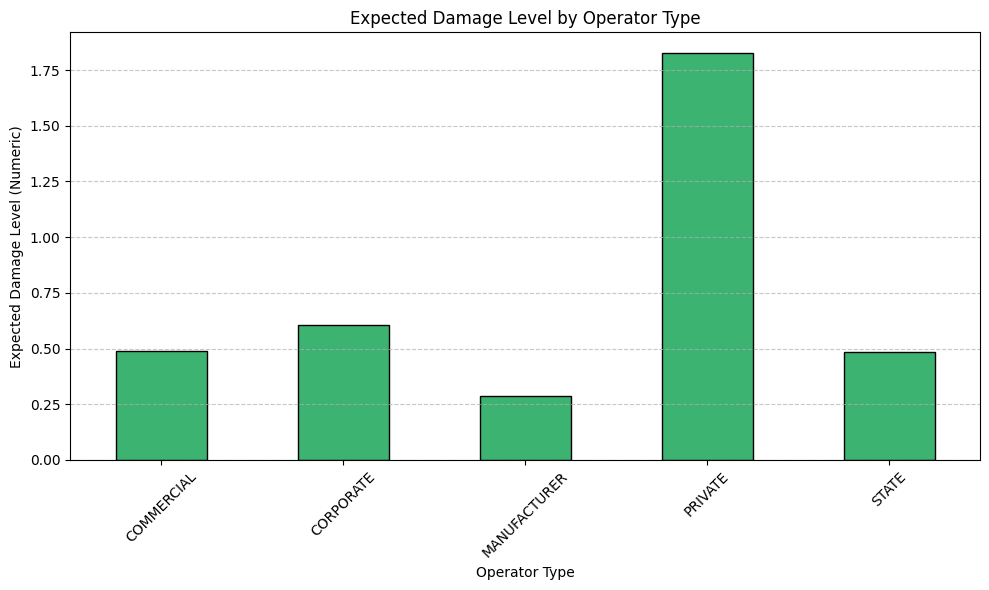

In [71]:
#Calculating the expected damage level for each operator type
filtered_df = df[(df["OperatorTypeID_DisplayEng"] != "UNKNOWN") & (df["OperatorTypeID_DisplayEng"] != "OTHER")].copy()
expected_damage_operator = filtered_df.groupby('OperatorTypeID_DisplayEng')['DamageLevelNumeric'].mean()
print(expected_damage_operator)

#Plotting
plt.figure(figsize=(10, 6))
expected_damage_operator.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Expected Damage Level by Operator Type')
plt.ylabel('Expected Damage Level (Numeric)')
plt.xlabel('Operator Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


ProvinceID_DisplayEng
ALBERTA                      0.849727
BRITISH COLUMBIA             0.915726
MANITOBA                     0.912632
NEW BRUNSWICK                0.818452
NEWFOUNDLAND AND LABRADOR    0.505882
NORTHWEST TERRITORIES        0.811952
NOVA SCOTIA                  0.460061
ONTARIO                      0.817100
QUEBEC                       0.920006
SASKATCHEWAN                 1.238420
YUKON                        1.348548
Name: DamageLevelNumeric, dtype: float64


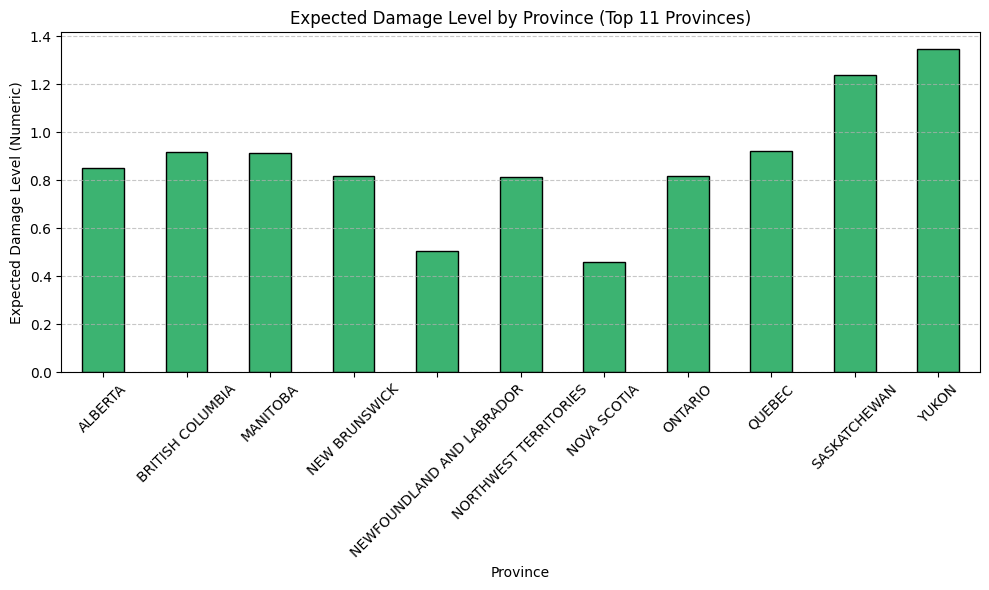

In [73]:
damage_mapping = {'NONE': 0, 'MINOR': 1, 'SUBSTANTIAL': 2}
df['DamageLevelNumeric'] = df['DamageLevelID_DisplayEng'].map(damage_mapping)

#11 most frequent provinces
top_11_provinces = df['ProvinceID_DisplayEng'].value_counts().nlargest(11).index

#Filter data for the top 11 provinces
filtered_df = df[df['ProvinceID_DisplayEng'].isin(top_11_provinces)].copy()

#Calculate the expected damage level for each province
expected_damage_province = filtered_df.groupby('ProvinceID_DisplayEng')['DamageLevelNumeric'].mean()
print(expected_damage_province)

#Plotting
plt.figure(figsize=(10, 6))
expected_damage_province.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Expected Damage Level by Province (Top 11 Provinces)')
plt.ylabel('Expected Damage Level (Numeric)')
plt.xlabel('Province')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Correlations and dependencies 

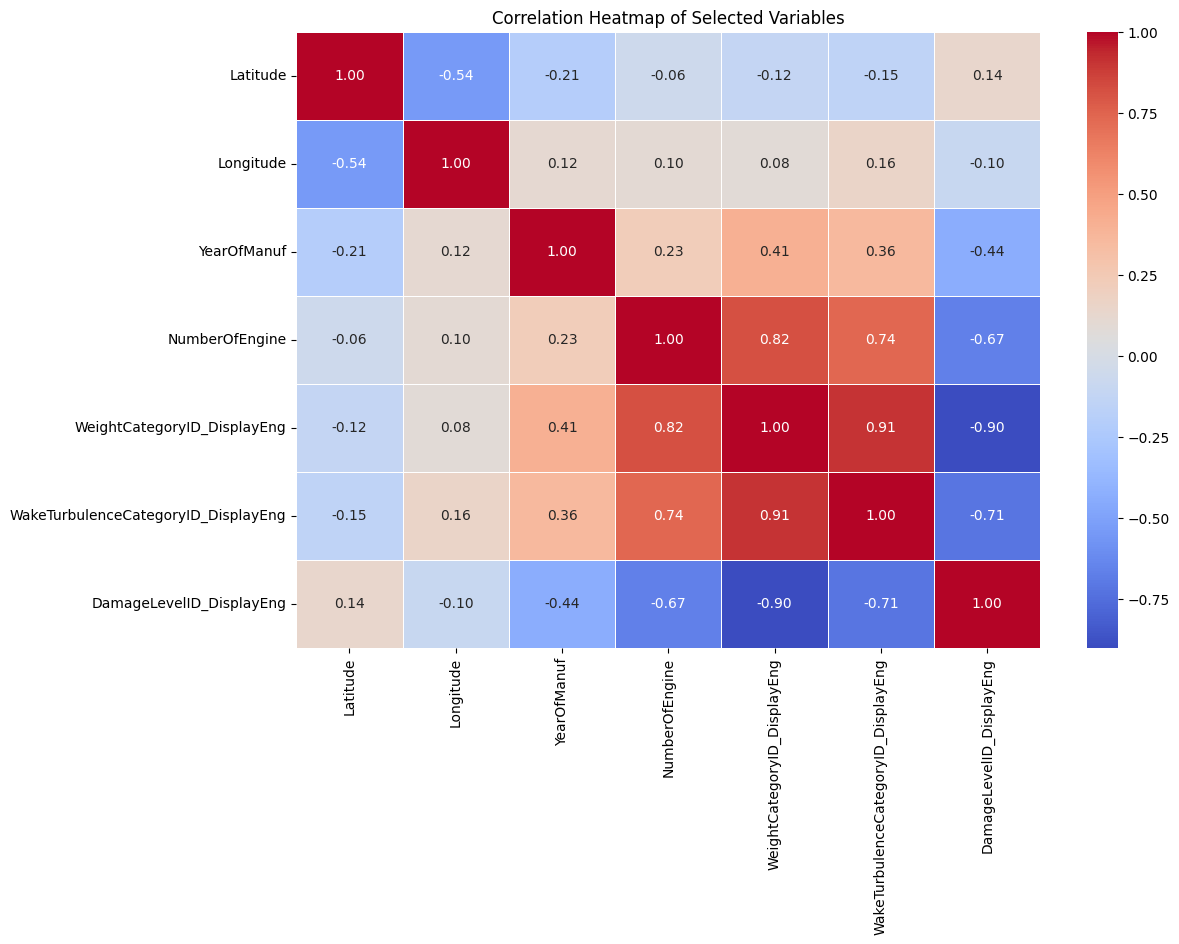

In [80]:
#Filtrar el DataFrame
filtered_df = df[
    (df['CountryID_DisplayEng'] == 'CANADA') &
    (df['ProvinceID_DisplayEng'].isin(selected_provinces))
]

#Columns for the heatmap
columns_for_heatmap = [
    'Latitude', 'Longitude', 'YearOfManuf', 'NumberOfEngine', 
    'WeightCategoryID_DisplayEng', 'WakeTurbulenceCategoryID_DisplayEng',
    'DamageLevelID_DisplayEng'
]

#Creating a numeric dataframe to calculate correlations
mapped_df = filtered_df[columns_for_heatmap].copy()

category_mappings = {
    'WeightCategoryID_DisplayEng': {
        '0-2250 KG       (0-4960 LBS)': 1,
        '2251-5700 KG    (4961-12566 LBS)': 2,
        '5701-27000 KG   (12567-59525 LBS)': 3,
        '27001-272000 KG (59526-599650 LBS)': 4
    },
    'WakeTurbulenceCategoryID_DisplayEng': {
        'LIGHT': 1, 'MEDIUM': 2, 'HEAVY': 3
    },
    'DamageLevelID_DisplayEng': {
        'NONE': 0, 'MINOR': 1, 'SUBSTANTIAL': 2, 'DESTROYED': 3
    }
}

for col, mapping in category_mappings.items():
    mapped_df[col] = filtered_df[col].map(mapping)

#Correlation matrix
correlation_matrix = mapped_df.corr()

#heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Selected Variables')
plt.show()